In [ ]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from copy import deepcopy

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.lenses.test import SampleStrongLens
from mejiro.exposure import Exposure
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [2]:
lens = SampleStrongLens()
roman = Roman()
band = 'F184'
scene_size = 5  # arcsec
oversample = 5
exposure_time = 146
instrument_params = {
    'detector': 1,
    'detector_position': (2048, 2048)
}

synth = SyntheticImage(lens, roman, band, arcsec=scene_size, oversample=oversample, pieces=False, verbose=True,
                       instrument_params=instrument_params)

Computing on pixel grid of size 235x235 (5.17"x5.17") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens SAMPLE by Roman in F184 band


In [11]:
from lenstronomy.SimulationAPI.ObservationConfig import Roman as RomanLenstronomy

roman_obs_config = RomanLenstronomy.Roman(band=band,
                                          psf_type='PIXEL',
                                          survey_mode='wide_area')

pprint(roman_obs_config.obs)

{'exposure_time': 146,
 'kernel_point_source': array([[4.28419938e-08, 4.67655620e-08, 5.33066952e-08, ...,
        8.75604177e-09, 1.02883914e-08, 1.16228895e-08],
       [3.69683304e-08, 3.54474015e-08, 3.72931822e-08, ...,
        1.12819727e-08, 1.11503164e-08, 1.17448107e-08],
       [3.38516535e-08, 3.19600563e-08, 2.97099952e-08, ...,
        1.10277278e-08, 1.06885127e-08, 1.16171050e-08],
       ...,
       [2.75852184e-08, 2.77561721e-08, 2.78249472e-08, ...,
        2.72439600e-08, 3.42879256e-08, 3.22762835e-08],
       [2.62954200e-08, 2.49480829e-08, 2.25557751e-08, ...,
        3.20994582e-08, 3.63163759e-08, 4.14690628e-08],
       [2.60802603e-08, 2.34410412e-08, 2.10910450e-08, ...,
        4.70832281e-08, 3.87049240e-08, 4.46360987e-08]]),
 'magnitude_zero_point': 25.95,
 'num_exposures': 96,
 'psf_type': 'PIXEL',
 'seeing': 0.151,
 'sky_brightness': 23.22}


In [3]:
from mejiro.engines import galsim_engine, lenstronomy_engine, pandeia_engine

print('Galsim')
pprint(galsim_engine.default_roman_engine_params())

print('\nLenstronomy')
pprint(lenstronomy_engine.default_roman_engine_params())

print('\nPandeia')
pprint(pandeia_engine.default_roman_engine_params())

Galsim
{'dark_noise': True,
 'detector_effects': True,
 'ipc': True,
 'nonlinearity': True,
 'poisson_noise': True,
 'read_noise': True,
 'reciprocity_failure': True,
 'rng': galsim.UniformDeviate(seed='812239652 1970235701 3299693958 ... 876553515 2415570789 899044626'),
 'sky_background': True}

Lenstronomy
{'kwargs_numerics': {'compute_mode': 'regular', 'supersampling_factor': 3},
 'noise': True}

Pandeia
{'calculation': {'effects': {'saturation': True},
                 'noise': {'crs': True,
                           'dark': True,
                           'excess': False,
                           'ffnoise': True,
                           'readnoise': True,
                           'scatter': False}},
 'num_samples': 10000,
 'sky_background': True}


In [4]:
galsim = Exposure(deepcopy(synth), exposure_time=exposure_time, engine='galsim', verbose=True)

# galsim returns the exposure in units of counts instead of counts/sec
galsim.exposure /= galsim.exposure_time
galsim.noise /= galsim.exposure_time

PSF F184 SCA01 (2048, 2048) 5 101 not found in cache /data/bwedig/mejiro/cached_psfs
Exposure calculation time with galsim engine: 0:00:22


In [ ]:
lenstronomy = Exposure(deepcopy(synth), exposure_time=exposure_time, engine='lenstronomy', verbose=True)

Exposure calculation time with lenstronomy engine: 0:00:00


In [6]:
engine_params = {
    'num_samples': 100
}

pandeia = Exposure(deepcopy(synth), exposure_time=exposure_time, engine='pandeia', engine_params=engine_params,
                   verbose=True)

100%|██████████| 98/98 [00:00<00:00, 107.73it/s]


Point source conversion complete: placed 98 point sources
Exposure calculation time with pandeia engine: 0:00:10


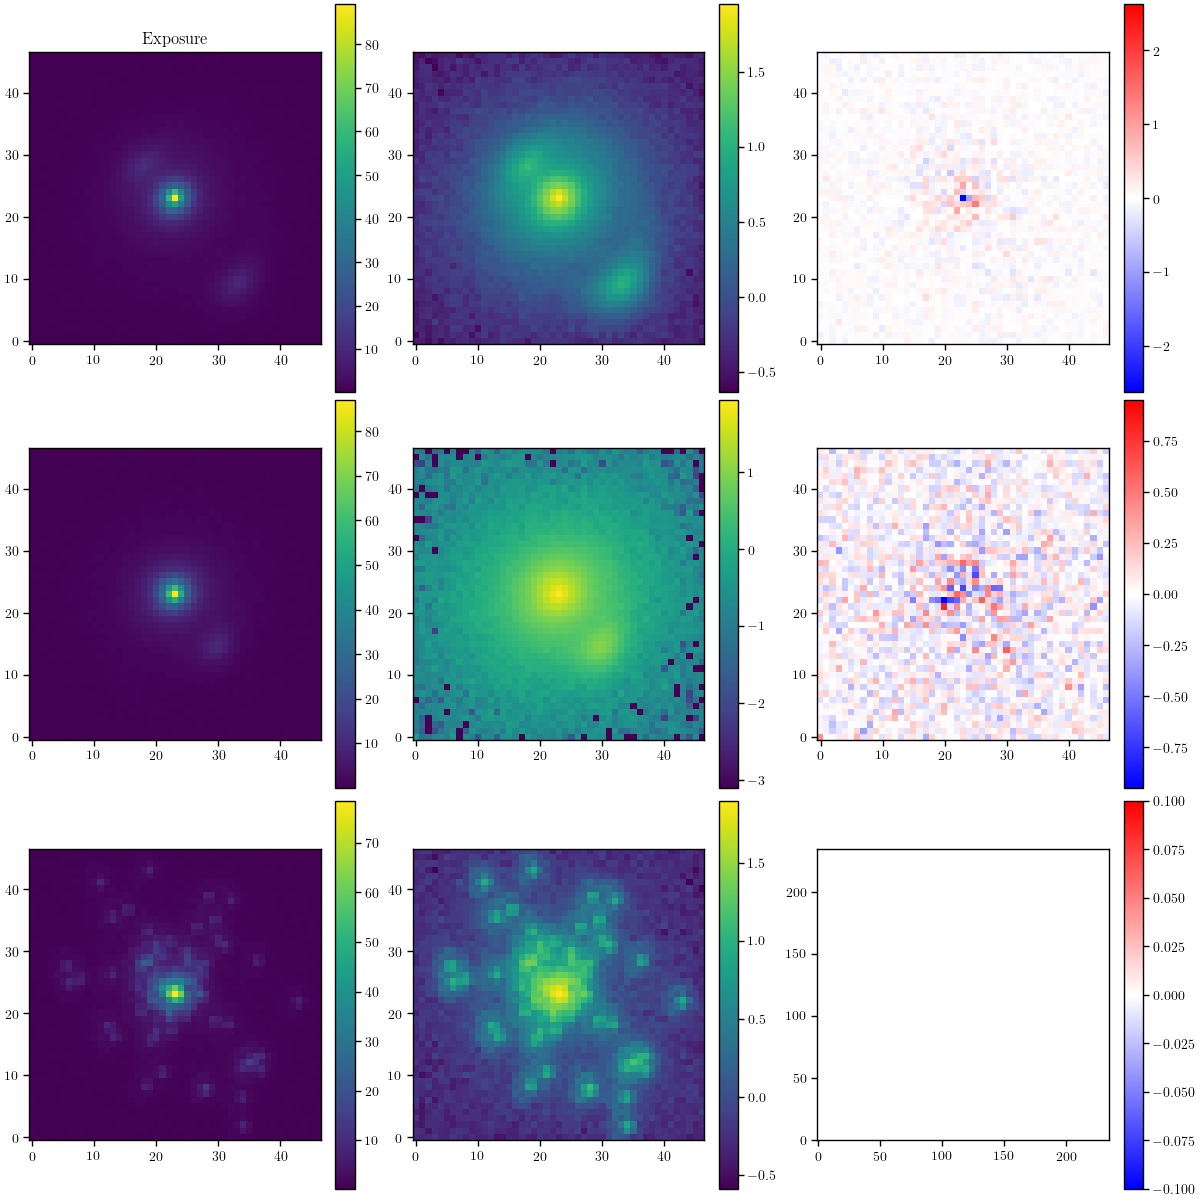

In [7]:
_, ax = plt.subplots(3, 3, figsize=(12, 12), constrained_layout=True)

# Galsim
ax00 = ax[0, 0].imshow(galsim.exposure)
ax01 = ax[0, 1].imshow(np.log10(galsim.exposure))
ax02 = ax[0, 2].imshow(galsim.noise, cmap='bwr', vmin=-plot_util.get_v(galsim.noise),
                       vmax=plot_util.get_v(galsim.noise))
plt.colorbar(ax00, ax=ax[0, 0])
plt.colorbar(ax01, ax=ax[0, 1])
plt.colorbar(ax02, ax=ax[0, 2])
ax[0, 0].set_title('Exposure')

# Lenstronomy
ax10 = ax[1, 0].imshow(lenstronomy.exposure)
ax11 = ax[1, 1].imshow(np.log10(lenstronomy.exposure))
ax12 = ax[1, 2].imshow(lenstronomy.noise, cmap='bwr', vmin=-plot_util.get_v(lenstronomy.noise),
                       vmax=plot_util.get_v(lenstronomy.noise))
plt.colorbar(ax10, ax=ax[1, 0])
plt.colorbar(ax11, ax=ax[1, 1])
plt.colorbar(ax12, ax=ax[1, 2])

# Pandeia
ax20 = ax[2, 0].imshow(pandeia.exposure)
ax21 = ax[2, 1].imshow(np.log10(pandeia.exposure))
ax22 = ax[2, 2].imshow(pandeia.noise, cmap='bwr', vmin=-plot_util.get_v(pandeia.noise),
                       vmax=plot_util.get_v(pandeia.noise))
plt.colorbar(ax20, ax=ax[2, 0])
plt.colorbar(ax21, ax=ax[2, 1])
plt.colorbar(ax22, ax=ax[2, 2])

plt.show()

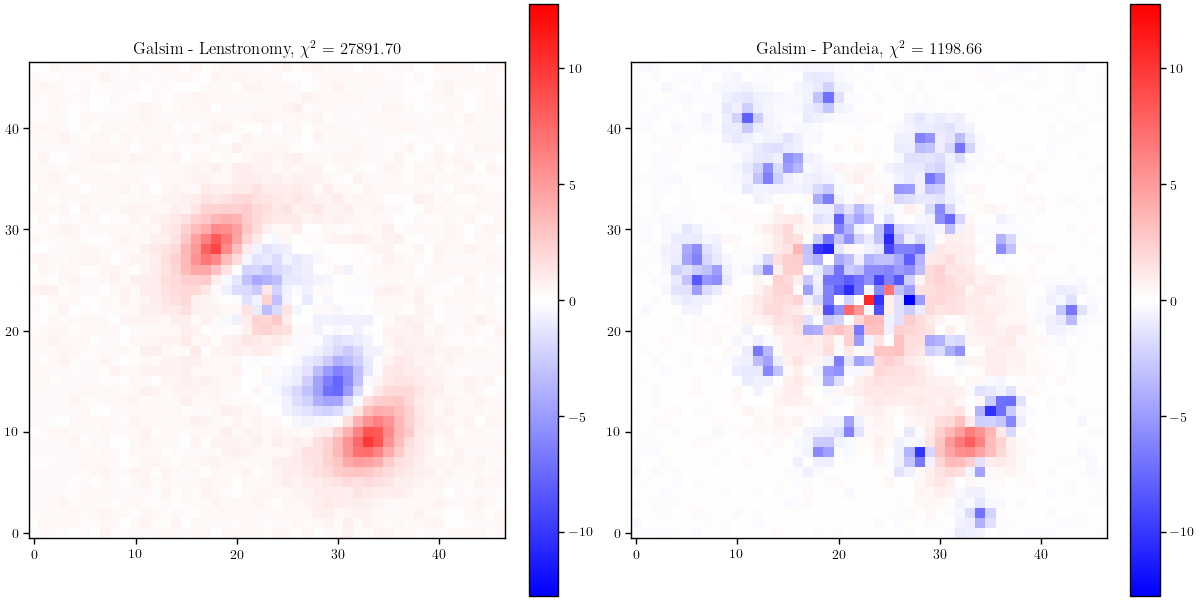

In [8]:
# Calculate residuals
residual_lenstronomy = galsim.exposure - lenstronomy.exposure
residual_pandeia = galsim.exposure - pandeia.exposure

# Plot residuals
_, ax_residuals = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# get v
v = plot_util.get_v([residual_lenstronomy, residual_pandeia])

# Lenstronomy residuals
ax_residuals[0].imshow(residual_lenstronomy, cmap='bwr', vmin=-v, vmax=v)
ax_residuals[0].set_title(
    'Galsim - Lenstronomy, ' + r'$\chi^2$ = ' + f'{stats.chi_square(galsim.exposure, lenstronomy.exposure):.2f}')
plt.colorbar(ax_residuals[0].images[0], ax=ax_residuals[0])

# Pandeia residuals
ax_residuals[1].imshow(residual_pandeia, cmap='bwr', vmin=-v, vmax=v)
ax_residuals[1].set_title(
    'Galsim - Pandeia, ' + r'$\chi^2$ = ' + f'{stats.chi_square(galsim.exposure, pandeia.exposure):.2f}')
plt.colorbar(ax_residuals[1].images[0], ax=ax_residuals[1])

plt.show()